In [31]:
import pandas as pd
from sqlalchemy import create_engine
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

sns.set(style="whitegrid")
RANDOM_STATE = 42

os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

**Load Data**

In [32]:

# Replace with your actual DB credentials
username = 'root'
password = os.getenv("MYSQL_PWD")  
host = 'localhost'
port = '3306'
database = 'bank_data'

In [33]:

# Create DB engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [34]:

# Load data
query = 'SELECT * FROM bank_customers;'  
df = pd.read_sql(query, engine)
df.head()

,id,age,job,marital,education,default_status,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group,balance_group
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,46-60,High
1,2,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,46-60,Low
2,3,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,30-45,Medium
3,4,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,46-60,High
4,5,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,46-60,Low


In [35]:
# Total number of rows and columns 
def df_shape(df):
    """ 
    Prints the number of rows and columns

    Parameter:
        df.Dataframe
    Return:
        None   
    """ 
    print(f'Total rows:{df.shape[0]}\nTotal columns:{df.shape[1]}')

df_shape(df)

Total rows:11162
Total columns:20


In [36]:
# Features
def features(df):
    """ 
    Enlists columns in the dataframe

    Parameter:
        df(pd.DataFrame)

    Return:
        None        
    """
    print(f'Columns: {df.columns.tolist()}')

features(df)

Columns: ['id', 'age', 'job', 'marital', 'education', 'default_status', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'age_group', 'balance_group']


**Initial EDA**

In [37]:
# Data types
print('\nData types:')
df.dtypes


Data types:


id                 int64
age                int64
job               object
marital           object
education         object
default_status    object
balance            int64
housing           object
loan              object
contact           object
day                int64
month             object
duration           int64
campaign           int64
pdays              int64
previous           int64
poutcome          object
deposit           object
age_group         object
balance_group     object
dtype: object

In [38]:
# Null values
print('\nMissing values:')
df.isnull().sum()


Missing values:


id                0
age               0
job               0
marital           0
education         0
default_status    0
balance           0
housing           0
loan              0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
deposit           0
age_group         0
balance_group     0
dtype: int64

In [39]:
# Stats
print('\nDescriptive stats:')
df.describe()


Descriptive stats:


,id,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5581.500000,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,3222.336187,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,1.000000,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,2791.250000,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,5581.500000,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,8371.750000,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,11162.000000,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


**Data Cleaning**

In [40]:
def clean_df(df):
    ''' 
    cleans the input by removing the null values, duplicate rows and the rows
    containing age less than 0.
    
    Parameter:
        df(df.DataFrame)

    Return:
        pd.DataFrame: Cleaned DataFrame        
    '''

    df = df.drop_duplicates()
    df = df.dropna()

    if 'age' in df.columns:
        df = df[df['age'] > 0]

    return df    


In [41]:
df = clean_df(df)

In [42]:
df_shape(df)

Total rows:11162
Total columns:20


**Visualize Distributions**

In [43]:
def numeric_features(df):
    """ 
    Returns a list of numeric columns numeric_features
    
    Parameter:
        df(df.DataFrame)

    Return:
        list: names of numeric columns        
    """
    numeric_columns = df.select_dtypes(include='number').columns.tolist()
    return numeric_columns 

numeric_columns = numeric_features(df)
numeric_columns

['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [44]:
# Histograms for numeric features
def plot_numeric_distributions(df,numeric_features):
    """ 
    Plots histogram + KDE for each numeric features

    Parameters:
        df(df.DataFrame)
        numeric_features (list): List of numeric features

    Return:
        None        
    """
    for feature in numeric_features:
        if feature in df.columns:
            plt.figure(figsize=(6,4))
            sns.histplot(
                df[feature],
                kde = True,
                bins = 30,
                color='steelblue'
            )
            plt.title(f'Distribution of {feature}')
            plt.tight_layout()
            plt.show()


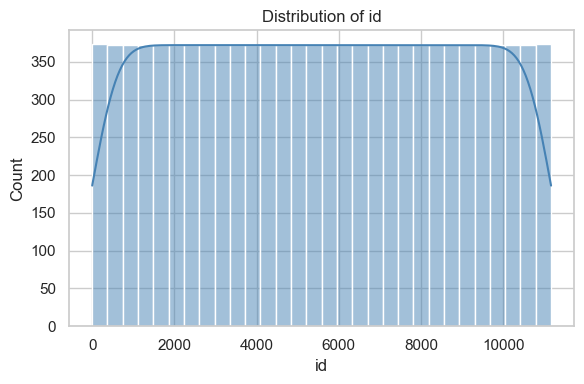

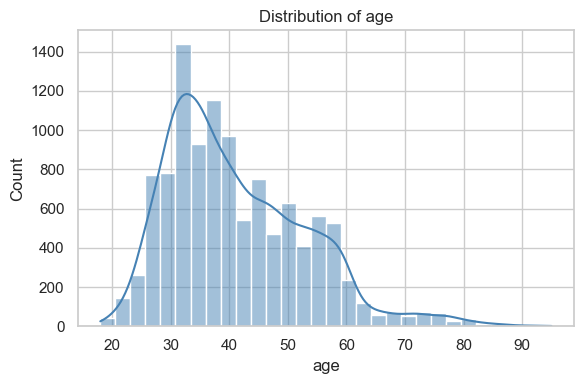

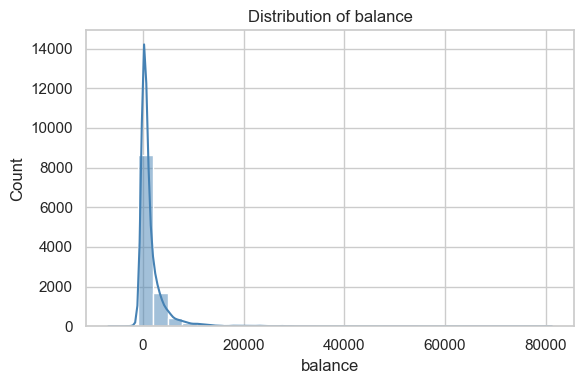

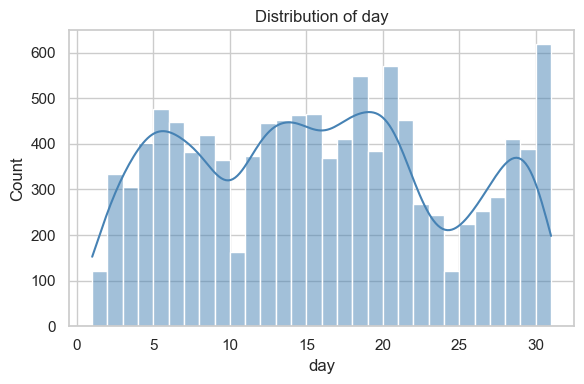

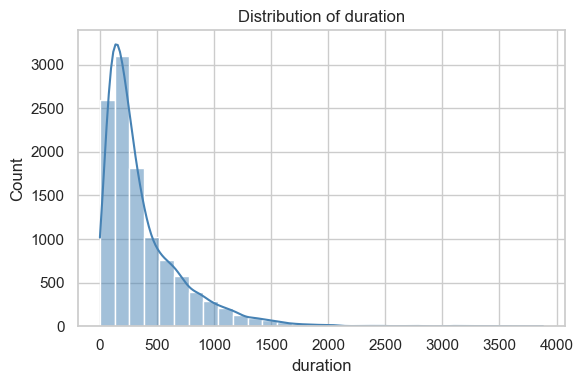

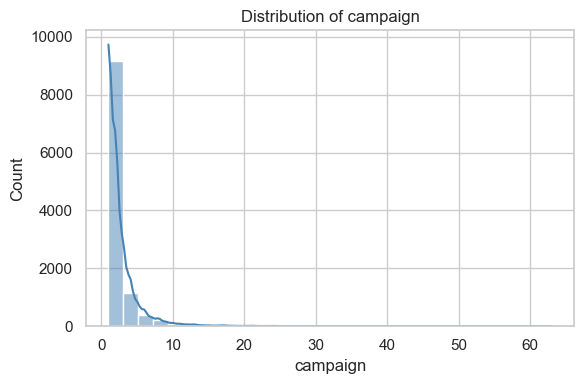

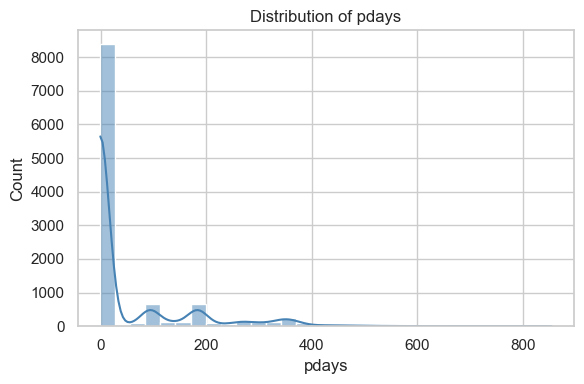

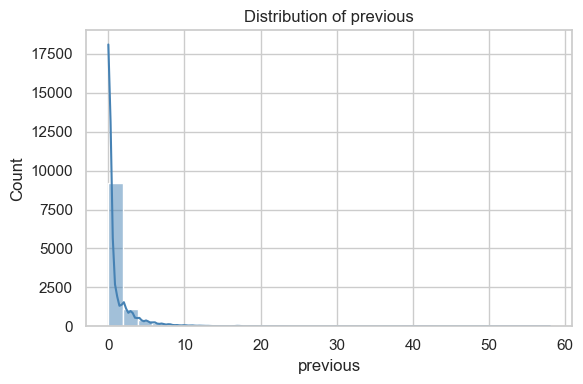

In [45]:
plot_numeric_distributions(df,numeric_columns)

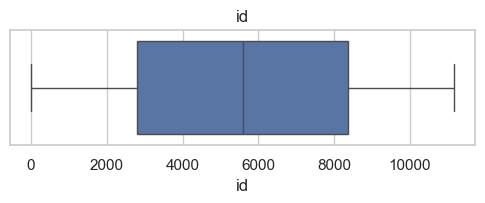

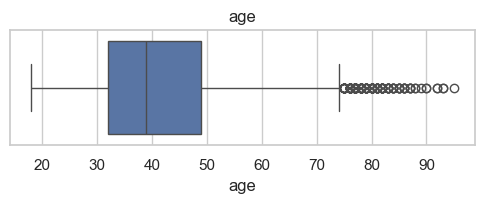

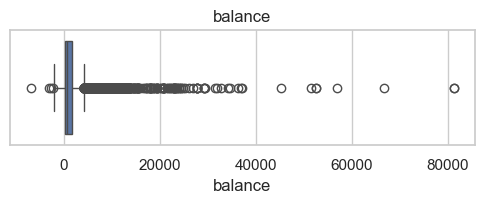

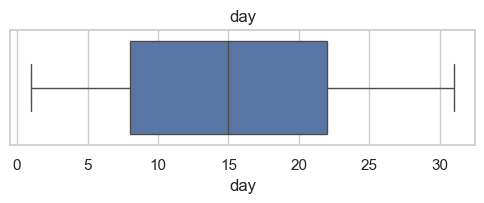

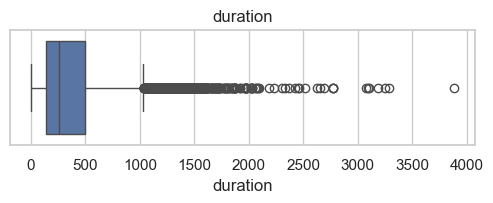

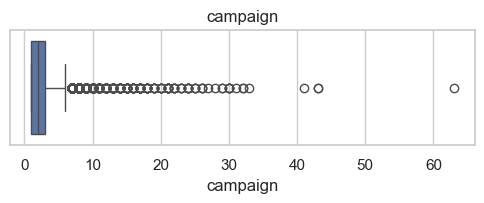

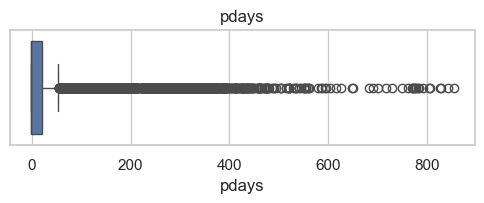

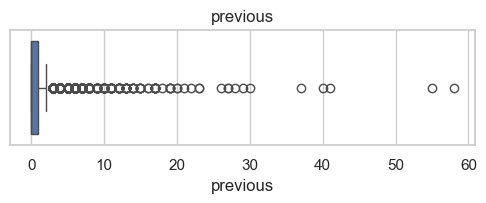

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

In [47]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    return df


In [48]:
numeric_columns = numeric_features(df)
df = cap_outliers_iqr(df, numeric_columns)


In [49]:
df_shape(df)

Total rows:11162
Total columns:20


**Encoding categorical features**

In [50]:
cols_to_drop = ['id', 'deposit', 'age_group', 'balance_group'] # Not useful for clustering
col_to_keep = [col for col in df.columns if col not in cols_to_drop]
df_cluster = df[col_to_keep]
df_cluster.head()

,age,job,marital,education,default_status,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,59.0,admin.,married,secondary,no,2343.0,yes,no,unknown,5.0,may,1033.0,1.0,-1.0,0.0,unknown
1,56.0,admin.,married,secondary,no,45.0,no,no,unknown,5.0,may,1033.0,1.0,-1.0,0.0,unknown
2,41.0,technician,married,secondary,no,1270.0,yes,no,unknown,5.0,may,1033.0,1.0,-1.0,0.0,unknown
3,55.0,services,married,secondary,no,2476.0,yes,no,unknown,5.0,may,579.0,1.0,-1.0,0.0,unknown
4,54.0,admin.,married,tertiary,no,184.0,no,no,unknown,5.0,may,673.0,2.0,-1.0,0.0,unknown


In [51]:
df_encoded = pd.get_dummies(df_cluster,drop_first=True)
df_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59.0,2343.0,5.0,1033.0,1.0,-1.0,0.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,56.0,45.0,5.0,1033.0,1.0,-1.0,0.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,41.0,1270.0,5.0,1033.0,1.0,-1.0,0.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,55.0,2476.0,5.0,579.0,1.0,-1.0,0.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,54.0,184.0,5.0,673.0,2.0,-1.0,0.0,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [52]:
# shape
df_shape(df_cluster)

Total rows:11162
Total columns:16


**Feature scaling**

In [53]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

In [54]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.530858,0.908149,-1.265746,2.388642,-0.814270,-0.578658,-0.543848,-0.459229,-0.173997,-0.158636,...,-0.396136,-0.350625,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.224814,-0.325782,0.583626
1,1.273537,-0.794565,-1.265746,2.388642,-0.814270,-0.578658,-0.543848,-0.459229,-0.173997,-0.158636,...,-0.396136,-0.350625,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.224814,-0.325782,0.583626
2,-0.013067,0.113105,-1.265746,2.388642,-0.814270,-0.578658,-0.543848,-0.459229,-0.173997,-0.158636,...,-0.396136,-0.350625,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.224814,-0.325782,0.583626
3,1.187764,1.006696,-1.265746,0.793993,-0.814270,-0.578658,-0.543848,-0.459229,-0.173997,-0.158636,...,-0.396136,-0.350625,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.224814,-0.325782,0.583626
4,1.101990,-0.691572,-1.265746,1.124163,-0.156846,-0.578658,-0.543848,-0.459229,-0.173997,-0.158636,...,-0.396136,-0.350625,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.224814,-0.325782,0.583626


**PCA for 2D Visualization**

In [55]:
# Apply Principal Component Analysis to reduce features to 2D for visualization.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
df_pca.head()

,PCA1,PCA2
0,-1.704593,1.273371
1,-1.647393,0.949267
2,-1.881679,1.917425
3,-1.859316,1.899603
4,-1.290662,-0.652966


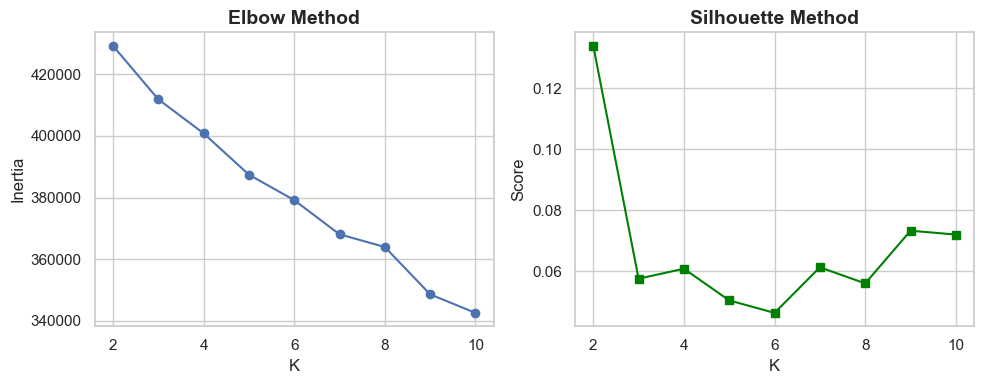

In [56]:
def plot_elbow_and_silhouette(data,max_k=10):
    """ 
    Plots elbow and silhouette for identification of ideal number of k.

    Parameters:
        data = pd.DataFrame(data)

    Return:
        None        
    """
    inertia = []
    silhouette = []

    for k in range(2,max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        prediction = kmeans.fit_predict(data)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(data,prediction))

    # Plot   

    plt.figure(figsize=(10,4))

    # Elbow method
    plt.subplot(1,2,1)
    plt.plot(range(2,max_k+1),inertia,marker='o')
    plt.title("Elbow Method",fontsize=14,fontweight='bold')
    plt.xlabel("K")
    plt.ylabel("Inertia")

    # Silhouette method
    plt.subplot(1,2,2)
    plt.plot(range(2,max_k+1),silhouette,marker='s',color='green')
    plt.title("Silhouette Method",fontsize=14,fontweight='bold')
    plt.xlabel('K')
    plt.ylabel("Score")
    
    plt.tight_layout()
    plt.show()

plot_elbow_and_silhouette(df_scaled)


**Fit Final KMeans Model**

In [57]:
# Optimal k = 4, we fit the model and assign cluster labels.
kmeans = KMeans(n_clusters=4,random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(df_pca)

df['clusters'] = clusters
df['clusters'] = clusters
df.head()

,id,age,job,marital,education,default_status,balance,housing,loan,contact,...,month,duration,campaign,pdays,previous,poutcome,deposit,age_group,balance_group,clusters
0,1.0,59.0,admin.,married,secondary,no,2343.0,yes,no,unknown,...,may,1033.0,1.0,-1.0,0.0,unknown,yes,46-60,High,1
1,2.0,56.0,admin.,married,secondary,no,45.0,no,no,unknown,...,may,1033.0,1.0,-1.0,0.0,unknown,yes,46-60,Low,1
2,3.0,41.0,technician,married,secondary,no,1270.0,yes,no,unknown,...,may,1033.0,1.0,-1.0,0.0,unknown,yes,30-45,Medium,1
3,4.0,55.0,services,married,secondary,no,2476.0,yes,no,unknown,...,may,579.0,1.0,-1.0,0.0,unknown,yes,46-60,High,1
4,5.0,54.0,admin.,married,tertiary,no,184.0,no,no,unknown,...,may,673.0,2.0,-1.0,0.0,unknown,yes,46-60,Low,0


In [58]:
# Assigning labels to the cluster
cluster_labels = {
    0: "Balanced Middle-Aged",
    1: "Younger Low-Balance",  # corrected
    2: "High-Balance Low Campaign",
    3: "Younger Lower-Balance"
}
df_pca['clusters'] = clusters

df_pca['cluster_labels'] = df_pca['clusters'].map(cluster_labels)
df_pca

,PCA1,PCA2,clusters,cluster_labels
0,-1.704593,1.273371,1,Younger Low-Balance
1,-1.647393,0.949267,1,Younger Low-Balance
2,-1.881679,1.917425,1,Younger Low-Balance
3,-1.859316,1.899603,1,Younger Low-Balance
4,-1.290662,-0.652966,0,Balanced Middle-Aged
...,...,...,...,...
11157,-1.108720,1.021715,1,Younger Low-Balance
11158,-2.022514,0.814032,1,Younger Low-Balance
11159,-0.844356,0.129499,1,Younger Low-Balance
11160,2.051394,2.253167,3,Younger Lower-Balance


In [59]:
df['clusters'].value_counts()

clusters
1    4371
0    3955
3    1467
2    1369
Name: count, dtype: int64

**Cluster Profiling**

In [60]:
# Calculate the mean values of important features per cluster.
print(f'\nCluster profile (Mean by clusters):')
mean_by_clusters = (df.groupby('clusters')[['age','balance','duration','campaign']].mean())
mean_by_clusters


Cluster profile (Mean by clusters):


,age,balance,duration,campaign
clusters,,,,
0,44.564349,1330.902402,349.874336,2.505689
1,37.735072,813.196065,366.541295,2.236559
2,46.074142,1605.116143,339.956172,1.872900
3,37.542604,992.698705,332.860259,1.865712


**Label the clusters**

In [61]:
# Assigning meaningful lables to the clusters
cluster_labels = {
    0: "Balanced Middle-Aged",
    1: "Younger Low-Balance",  # corrected
    2: "High-Balance Low Campaign",
    3: "Younger Lower-Balance"
}

df['clusters_labels'] = df['clusters'].map(cluster_labels) 


df.head()


,id,age,job,marital,education,default_status,balance,housing,loan,contact,...,duration,campaign,pdays,previous,poutcome,deposit,age_group,balance_group,clusters,clusters_labels
0,1.0,59.0,admin.,married,secondary,no,2343.0,yes,no,unknown,...,1033.0,1.0,-1.0,0.0,unknown,yes,46-60,High,1,Younger Low-Balance
1,2.0,56.0,admin.,married,secondary,no,45.0,no,no,unknown,...,1033.0,1.0,-1.0,0.0,unknown,yes,46-60,Low,1,Younger Low-Balance
2,3.0,41.0,technician,married,secondary,no,1270.0,yes,no,unknown,...,1033.0,1.0,-1.0,0.0,unknown,yes,30-45,Medium,1,Younger Low-Balance
3,4.0,55.0,services,married,secondary,no,2476.0,yes,no,unknown,...,579.0,1.0,-1.0,0.0,unknown,yes,46-60,High,1,Younger Low-Balance
4,5.0,54.0,admin.,married,tertiary,no,184.0,no,no,unknown,...,673.0,2.0,-1.0,0.0,unknown,yes,46-60,Low,0,Balanced Middle-Aged


**Visualize Final Clusters**

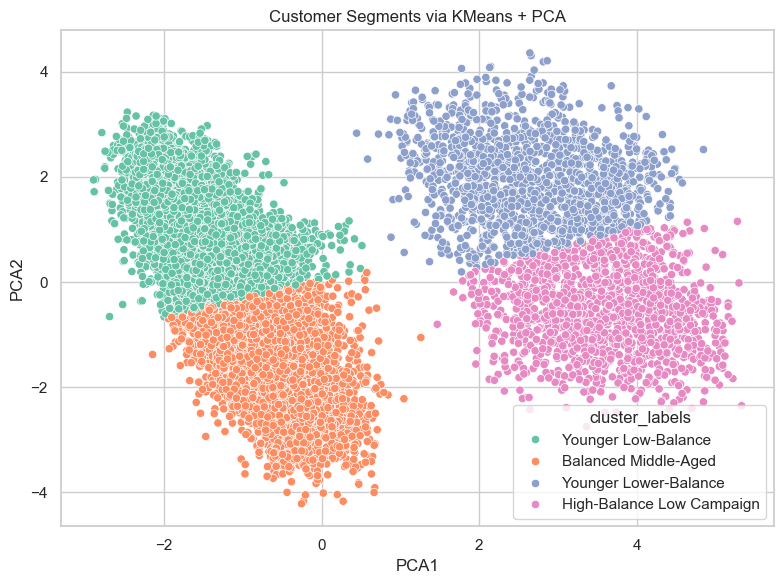

In [62]:
# We visualize customer segments on 2D PCA-reduced space.

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x = 'PCA1',
    y = 'PCA2',
    hue= 'cluster_labels',
    palette='Set2',
)
plt.title("Customer Segments via KMeans + PCA")
plt.tight_layout()
plt.show()

**Save Model & Scaler**

In [63]:
import joblib

# We save the KMeans model and scaler for future inference.
joblib.dump(kmeans, "models/kmeans_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']